## KDD BR Competition 2018 - Predicting palm oil production

The goal here is to predict palm oil harvest productivity with data provided by AGROPALMA. The dataset contains information about palm trees, their harvest dates, atmospheric data during development of the plants and soil characteristics of the fields where the trees are located in.

**By: Ana Giulia Moreira de Lima**

In [562]:
#Importing libraries

import pandas as pd
from pandas import merge
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as skl
import glob
import os
from os import listdir

In [563]:
#Preprocessing
from sklearn.preprocessing import StandardScaler

#Preparing to import algorithms

from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model

from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LogisticRegression

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split


from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer


### Starting with train and test dataframes

In [564]:
train = pd.read_csv('dataset/train.csv')
test = pd.read_csv('dataset/test.csv')

test.head(3)

,Id,field,age,type,harvest_year,harvest_month
0,5243,0,27,5,2012,1
1,5244,0,27,5,2012,2
2,5245,0,27,5,2012,3


In [565]:
train.head(3)

,Id,field,age,type,harvest_year,harvest_month,production
0,0,0,19,5,2004,1,0.064071
1,1,0,19,5,2004,2,0.047658
2,2,0,19,5,2004,3,0.016866


### Starting with field-*.csv files

In [566]:
dtField = pd.read_csv('dataset/field-0.csv')

dtField.head(3)

,month,year,temperature,dewpoint,windspeed,Soilwater_L1,Soilwater_L2,Soilwater_L3,Soilwater_L4,Precipitation
0,1,2002,26.008,24.434,1.8453,0.32984,0.32597,0.31477,0.29513,361.55
1,2,2002,25.774,24.734,1.9875,0.35884,0.35812,0.35536,0.34368,289.28
2,3,2002,25.777,24.609,1.7504,0.35886,0.35896,0.35898,0.36199,492.05


### Analysing similarities between Soilwater_L* columns and deciding if they're pertinent or not

<Axes: xlabel='Soilwater_L1', ylabel='Precipitation'>

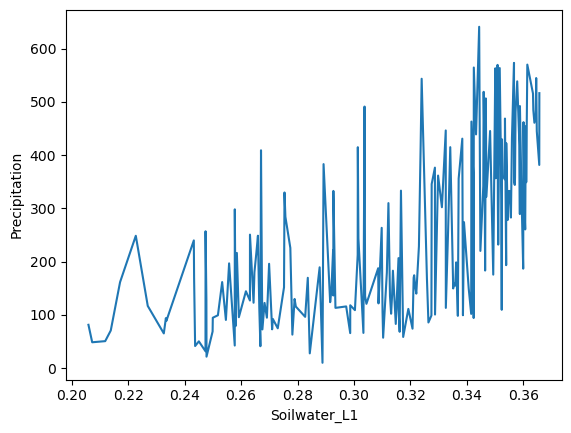

In [567]:
sns.lineplot(data = dtField, x='Soilwater_L1', y='Precipitation')

<Axes: xlabel='Soilwater_L2', ylabel='Precipitation'>

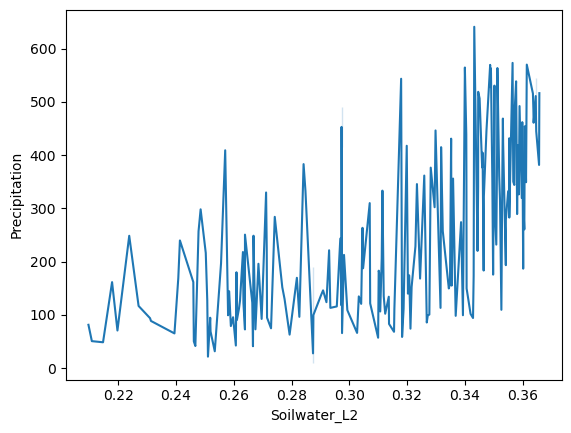

In [568]:
sns.lineplot(data = dtField, x='Soilwater_L2', y='Precipitation')

<Axes: xlabel='Soilwater_L3', ylabel='Precipitation'>

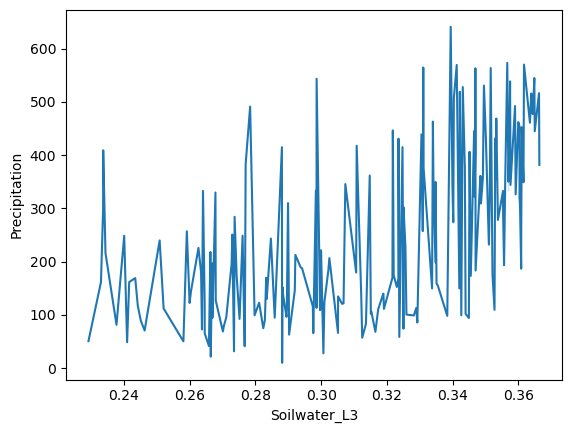

In [569]:
sns.lineplot(data = dtField, x='Soilwater_L3', y='Precipitation')

<Axes: xlabel='Soilwater_L4', ylabel='Precipitation'>

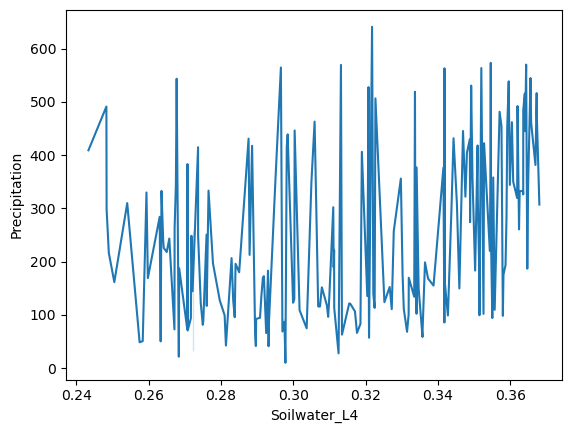

In [570]:
sns.lineplot(data = dtField, x='Soilwater_L4', y='Precipitation')

#### Note: 
Soilwater fields are kinda similar, there's no need to use all of them

### Dropping Soilwater_L* columns 2, 3 and 4

In [571]:
dtField.drop(['Soilwater_L2', 'Soilwater_L3', 'Soilwater_L4'], axis = 1, inplace=True)

dtField.head(3)

,month,year,temperature,dewpoint,windspeed,Soilwater_L1,Precipitation
0,1,2002,26.008,24.434,1.8453,0.32984,361.55
1,2,2002,25.774,24.734,1.9875,0.35884,289.28
2,3,2002,25.777,24.609,1.7504,0.35886,492.05


### Function to create a date column to help when plotting graphs

In [572]:
#defining dateformat for dataframe year and month
def dateformat(df):
     return pd.to_datetime((df.harvest_year*10000+df.harvest_month*100+1)\
                                  .apply(str),format='%Y%m%d')

for d in [train, test]:
    d['date'] = dateformat(d)

### Analysing production by year using the train dataset

Considering inconsistency between 2004-2006

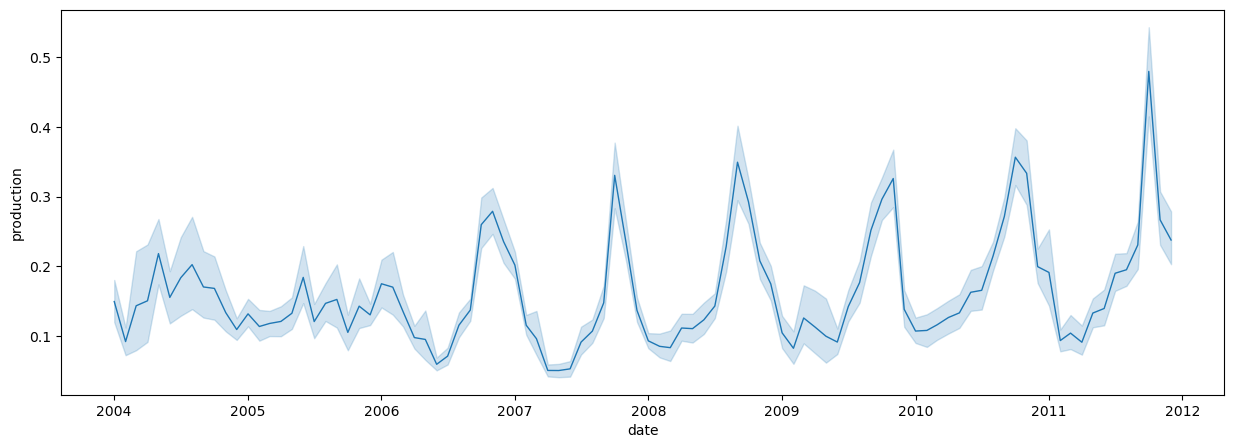

In [573]:
f, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(x='date', y='production', data=train, linewidth=1);

#### Note: 
2004 and 2005 are inconsistent, might drop them

In [574]:
train = train[train.harvest_year >= 2006]

In [575]:
train.head(3)

,Id,field,age,type,harvest_year,harvest_month,production,date
24,24,0,21,5,2006,1,0.121454,2006-01-01
25,25,0,21,5,2006,2,0.073829,2006-02-01
26,26,0,21,5,2006,3,0.053183,2006-03-01


### Renaming train and test columns

**harvest_year** is now **year** and **harvest_month** is now **month**, it will make it a lot easier to merge from now on

In [576]:
train['harvest_year'].unique()

array([2006, 2007, 2008, 2009, 2010, 2011], dtype=int64)

In [577]:
train.rename(columns={'harvest_year':'year', 'harvest_month': 'month'}, inplace=True)

train.head(2)

,Id,field,age,type,year,month,production,date
24,24,0,21,5,2006,1,0.121454,2006-01-01
25,25,0,21,5,2006,2,0.073829,2006-02-01


In [578]:
test['harvest_year'].unique()

array([2012, 2013, 2014, 2015, 2016, 2017], dtype=int64)

In [579]:
test.rename(columns={'harvest_year':'year', 'harvest_month': 'month'}, inplace=True)

test.head(2)

,Id,field,age,type,year,month,date
0,5243,0,27,5,2012,1,2012-01-01
1,5244,0,27,5,2012,2,2012-02-01


### Working again with field files

Since we're working with a time series, we need previous data to do predictions, when you give a model lagged versions of data, you improve the precision of predictions made by this model considering past values.

In [580]:
#Getting previous data from dataframe 12 times - we need to determine which columns will be used as features
#The code will create lagged versions of the feature concatenating the column name with a _b+the number of the repetition
#The shift method shifts the values of the feature column by x periods
def prev(dt, ft):
    for x in range(1,13):
        dt[f'{ft}_b{x}'] = dt[ft].shift(x)
    return dt

In [581]:
#Getting features we need to be repeated on a time series
features = ['temperature', 'dewpoint', 'windspeed', 'Soilwater_L1', 'Precipitation']
dtField['field'] = 0

#Using glob lib to get all field-* files but field-0
files = glob.glob('dataset/field-*')
filtering = [f for f in files if 'field-0' not in f]

#Getting every feature we've already mentioned
for ft in features:
    dtField = prev(dtField, ft)

In [582]:
dtField.head()

,month,year,temperature,dewpoint,windspeed,Soilwater_L1,Precipitation,field,temperature_b1,temperature_b2,...,Precipitation_b3,Precipitation_b4,Precipitation_b5,Precipitation_b6,Precipitation_b7,Precipitation_b8,Precipitation_b9,Precipitation_b10,Precipitation_b11,Precipitation_b12
0,1,2002,26.008,24.434,1.8453,0.32984,361.55,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2002,25.774,24.734,1.9875,0.35884,289.28,0,26.008,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2002,25.777,24.609,1.7504,0.35886,492.05,0,25.774,26.008,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2002,25.890,24.904,1.4950,0.36013,461.84,0,25.777,25.774,...,361.55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2002,26.182,24.826,1.8062,0.35567,282.69,0,25.890,25.777,...,289.28,361.55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [583]:
for x, field in enumerate(filtering):
    new_field = pd.read_csv(field)
    
    for ft in features:
        new_field = prev(new_field, ft)
        
    new_field['field'] = x + 1
    
    dtField = pd.concat([dtField, new_field])

In [584]:
new_field.head()

,month,year,temperature,dewpoint,windspeed,Soilwater_L1,Soilwater_L2,Soilwater_L3,Soilwater_L4,Precipitation,...,Precipitation_b4,Precipitation_b5,Precipitation_b6,Precipitation_b7,Precipitation_b8,Precipitation_b9,Precipitation_b10,Precipitation_b11,Precipitation_b12,field
0,1,2002,26.008,24.434,1.8453,0.32984,0.32597,0.31477,0.29513,332.64,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27
1,2,2002,25.774,24.734,1.9875,0.35884,0.35812,0.35536,0.34368,279.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27
2,3,2002,25.777,24.609,1.7504,0.35886,0.35896,0.35898,0.36199,494.39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27
3,4,2002,25.890,24.904,1.4950,0.36013,0.35991,0.35997,0.36043,465.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27
4,5,2002,26.182,24.826,1.8062,0.35567,0.35541,0.35536,0.35894,287.35,...,332.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27


In [585]:
train.head(2)

,Id,field,age,type,year,month,production,date
24,24,0,21,5,2006,1,0.121454,2006-01-01
25,25,0,21,5,2006,2,0.073829,2006-02-01


In [586]:
dtField.head()

,month,year,temperature,dewpoint,windspeed,Soilwater_L1,Precipitation,field,temperature_b1,temperature_b2,...,Precipitation_b6,Precipitation_b7,Precipitation_b8,Precipitation_b9,Precipitation_b10,Precipitation_b11,Precipitation_b12,Soilwater_L2,Soilwater_L3,Soilwater_L4
0,1,2002,26.008,24.434,1.8453,0.32984,361.55,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2002,25.774,24.734,1.9875,0.35884,289.28,0,26.008,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2002,25.777,24.609,1.7504,0.35886,492.05,0,25.774,26.008,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2002,25.890,24.904,1.4950,0.36013,461.84,0,25.777,25.774,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2002,26.182,24.826,1.8062,0.35567,282.69,0,25.890,25.777,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Merging dataframes with field dataframe according to field, year and month - row

In [587]:
train = pd.merge(dtField, train, on=['field', 'year', 'month'], sort=True, how='left')
train.sort_values('Id').to_csv('dataset/trained.csv', index=False)

test = merge(test, dtField, on=['field', 'year', 'month'], sort=True, how='left')
test.sort_values('Id').to_csv('dataset/tested.csv', index=False)

### Declaring files and trying to normalize data

Because of the merge, the production column seemed to acquire new rows with NaN values, this will mostly return a lot o ValueError from scikit when using such a null column, here we drop all the rows that have NaN values, there's a lot of other ways to solve this probably like using Imputers, for example.

In [588]:
trained_data = pd.read_csv('dataset/trained.csv')
tested_data = pd.read_csv('dataset/tested.csv')

trained_data = train.dropna()
trained_data['production'].isna().sum()

0

### Changing 'date' column data type to datetime64

Since **tested_data** and **trained_data** were originated from the merge of train and test dataframes to fields dataframe, tha column **date** is no longer presented with the Dtype datetime64, it is shown as an object considering pandas classifies something as an object when there is not only letters but special characters together.

In [589]:
tested_data['date'] = pd.to_datetime(tested_data['date'])

tested_data['date'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 4110 entries, 0 to 4109
Series name: date
Non-Null Count  Dtype         
--------------  -----         
4110 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 32.2 KB


In [590]:
trained_data['date'] = pd.to_datetime(trained_data['date'])

trained_data['date'].info()

<class 'pandas.core.series.Series'>
Int64Index: 3722 entries, 522 to 7402
Series name: date
Non-Null Count  Dtype         
--------------  -----         
3722 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 58.2 KB


C:\Users\anagi\AppData\Local\Temp\ipykernel_13988\2986861269.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trained_data['date'] = pd.to_datetime(trained_data['date'])


### Starting analysis function

Here we're using **HistGradientBoostingRegressor** since it is the only estimator tha allows NaN values for type regression according to scikit-learn documentation

In [591]:
def analyse_pred(trained_data, coluna):
    x = trained_data[coluna]
    y = trained_data['production']
    
    #Normalize data
    x = StandardScaler().fit_transform(x)
    
      
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1, shuffle=False)
    
    model = HistGradientBoostingRegressor()
    model.fit(x_train, y_train)
    
    #Predict
    prev = model.predict(x_test)
    
    sns.jointplot(x=y_test, y =prev, kind="reg", color="m", height=7)
    plt.savefig('graph/prev_graph.png')
    point = mean_absolute_error(y_test, prev)
    print('Score: ', point)

### Function for Mean Absolute Error Score

In [592]:
def kaggle_mea(trained_data, tested_data, coluna):
    
    model = HistGradientBoostingRegressor(max_iter = 100, max_depth=5, random_state=1)
    model.fit(trained_data[coluna], trained_data['production'])
    tested_data['production'] = model.predict(tested_data[coluna])
    
    all_data = pd.concat([trained_data, tested_data])
    _, eixo = plt.subplots(figsize=(12, 10))
    sns.lineplot(x='date', y='production', data=all_data, ax=eixo)
    plt.savefig('graph/byYear.png')

    
    return tested_data

### Applying functions based on columns specified and generating submission .csv file

**Obtained score:** 0.06774241133866515 

Score:  0.06774241133866515


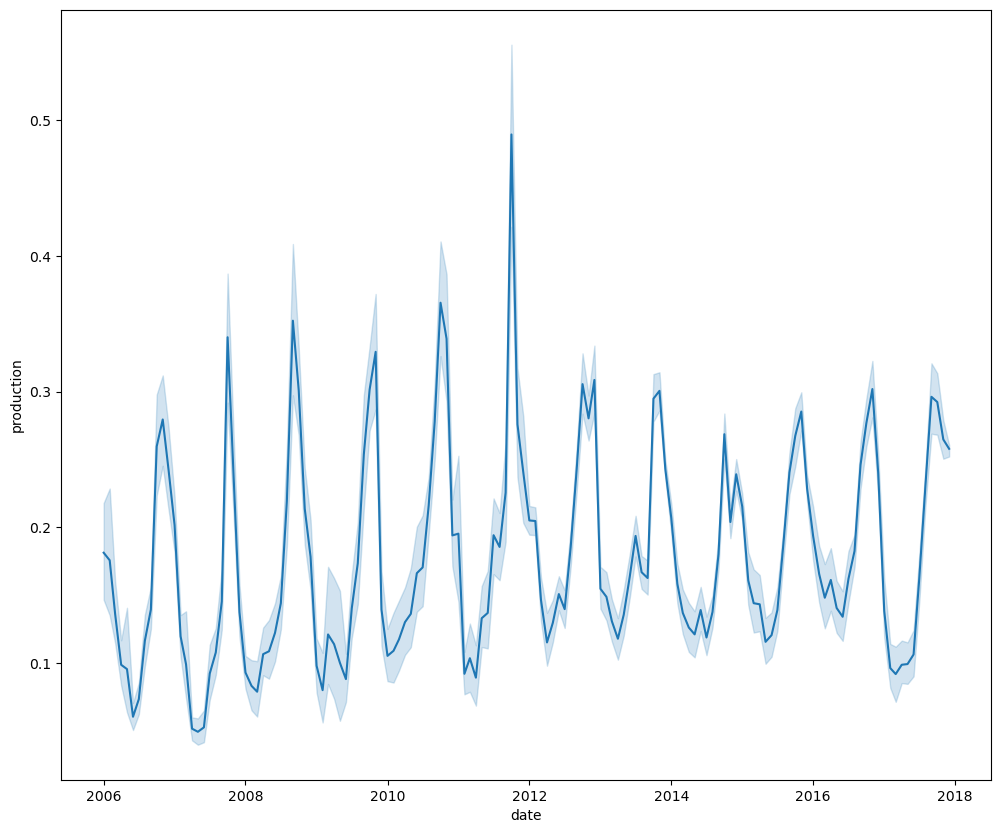

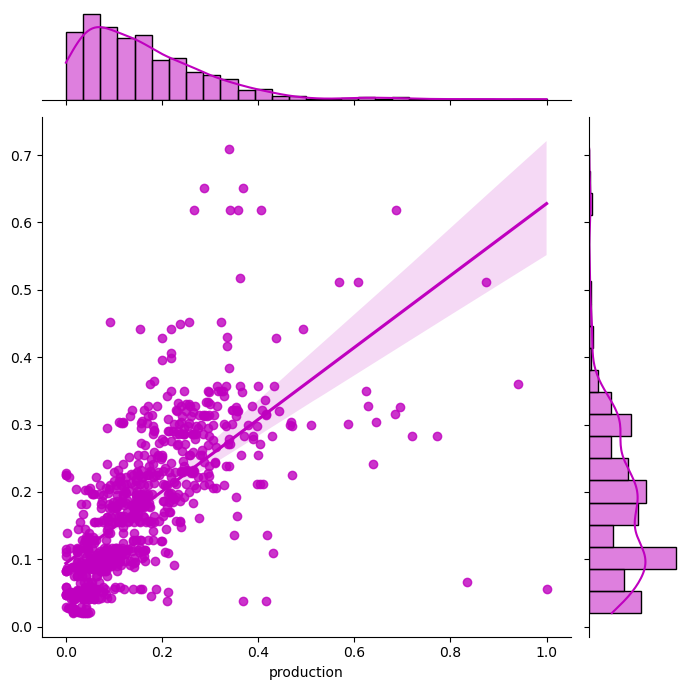

In [593]:
#Literally all the columns
props = ['field','age','type','year','month','temperature','dewpoint','windspeed','Soilwater_L1', 'Soilwater_L2', 'Soilwater_L3', 'Soilwater_L4','Precipitation','temperature_b1','temperature_b2','temperature_b3','temperature_b4','temperature_b5','temperature_b6','temperature_b7','temperature_b8','temperature_b9','temperature_b10','temperature_b11','temperature_b12','dewpoint_b1','dewpoint_b2','dewpoint_b3','dewpoint_b4','dewpoint_b5','dewpoint_b6','dewpoint_b7','dewpoint_b8','dewpoint_b9','dewpoint_b10','dewpoint_b11','dewpoint_b12','windspeed_b1','windspeed_b2','windspeed_b3','windspeed_b4','windspeed_b5','windspeed_b6','windspeed_b7','windspeed_b8','windspeed_b9','windspeed_b10','windspeed_b11','windspeed_b12','Soilwater_L1_b1','Soilwater_L1_b2','Soilwater_L1_b3','Soilwater_L1_b4','Soilwater_L1_b5','Soilwater_L1_b6','Soilwater_L1_b7','Soilwater_L1_b8','Soilwater_L1_b9','Soilwater_L1_b10','Soilwater_L1_b11','Soilwater_L1_b12','Precipitation_b1','Precipitation_b2','Precipitation_b3','Precipitation_b4','Precipitation_b5','Precipitation_b6','Precipitation_b7','Precipitation_b8','Precipitation_b9','Precipitation_b10','Precipitation_b11','Precipitation_b12']
predictions = kaggle_mea(trained_data, tested_data, props)
analyse_pred(trained_data, props)

submission = pd.DataFrame({'Id': predictions.Id, 'production': predictions.production})
submission.to_csv('KaggleSub.csv', index =False)

### Concatenating

Concatenating **trained_data** and **tested_data** just like used in function **kaggle_mea**

In [594]:
all_data = pd.concat([trained_data, tested_data])

### Graphs

Graphs according to specifications such as year, age, month and others

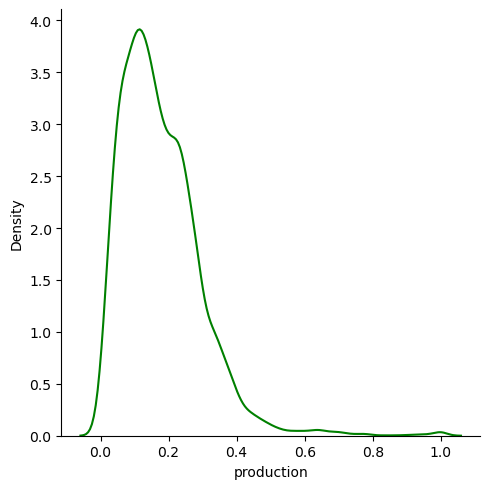

In [595]:
#Distribution
sns.displot(all_data.production, color='g', kind='kde')
plt.savefig('graph/distribution_production.png')

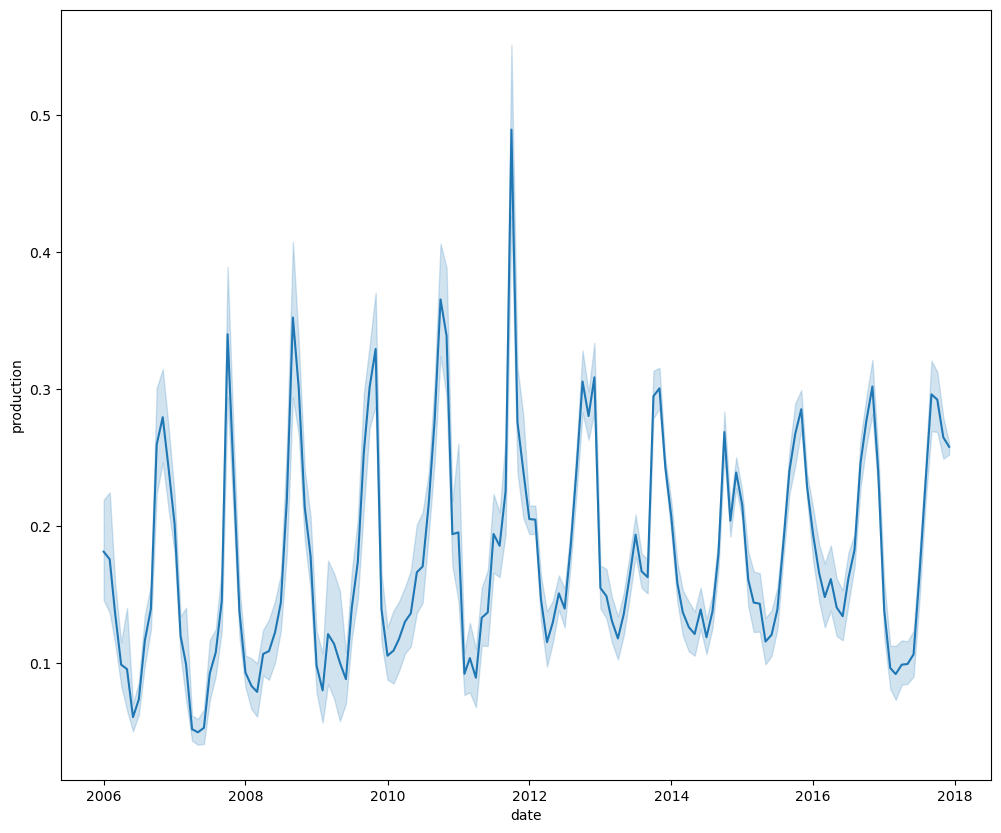

In [596]:
#By year - production
_, eixos = plt.subplots(figsize=(12, 10))
sns.lineplot(x='date', y='production', data=all_data, ax=eixos)
plt.savefig('graph/byYear_prod.png')

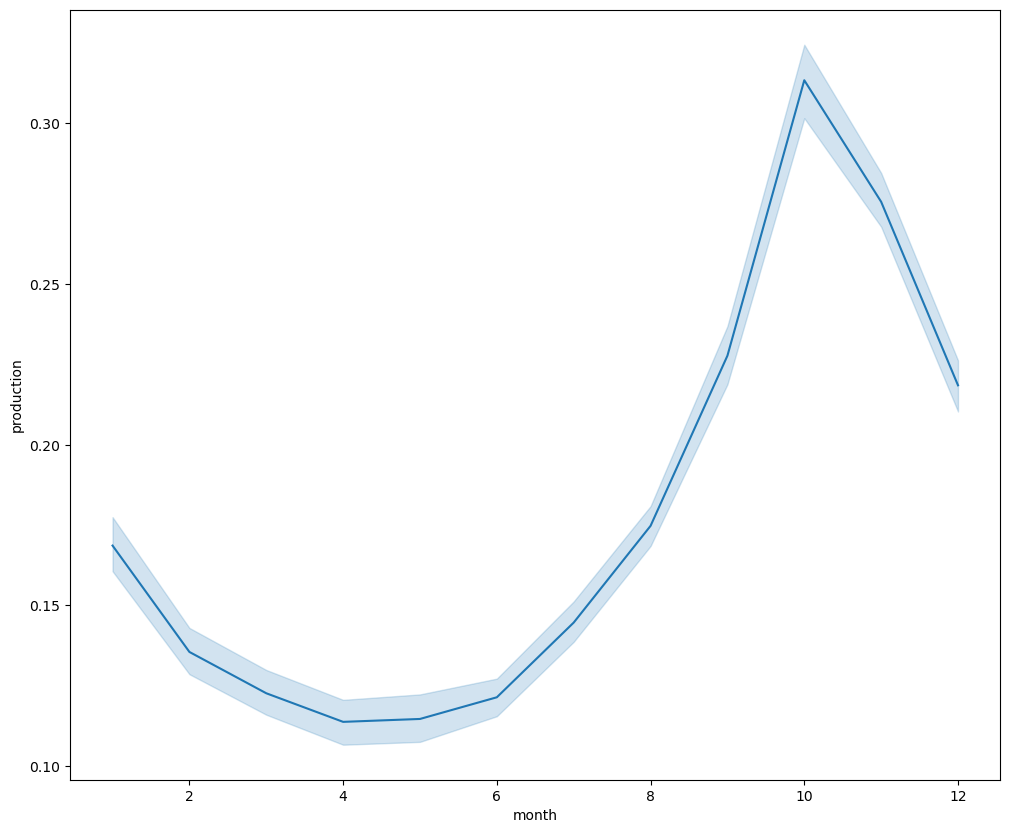

In [597]:
#By month - production
_, eixos = plt.subplots(figsize=(12, 10))
sns.lineplot(x='month', y='production', data=all_data, ax=eixos)
plt.savefig('graph/byMonth_prod.png')

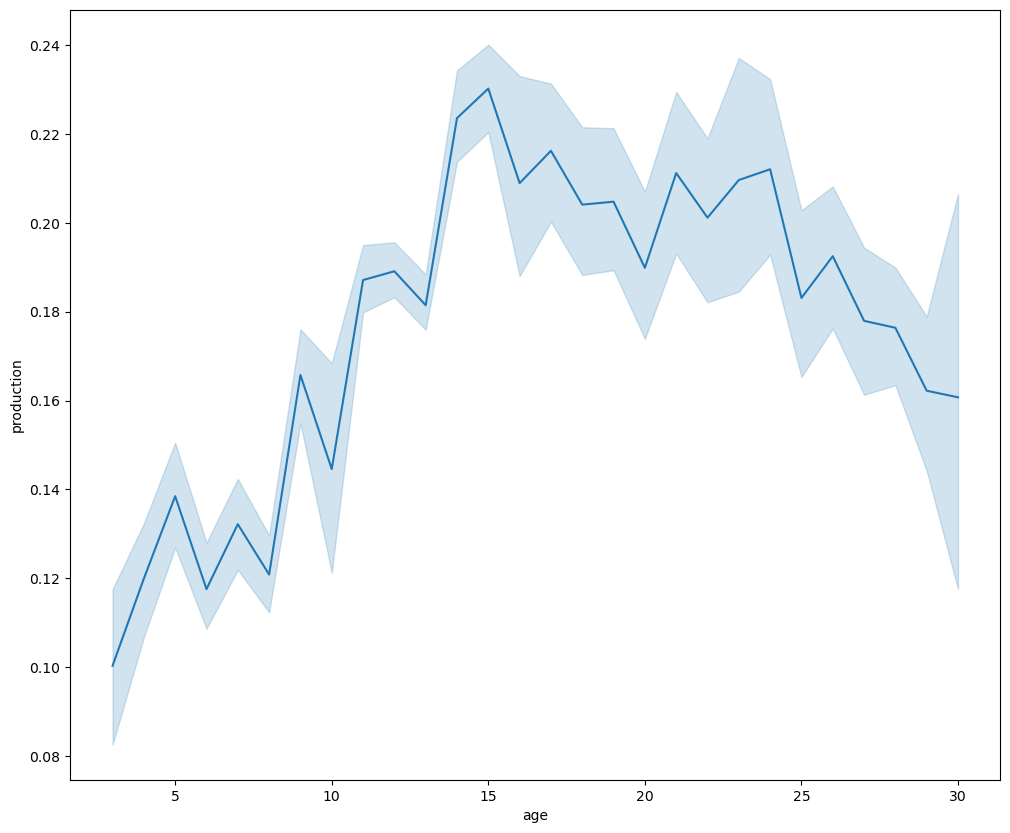

In [598]:
#By age - production
_, eixos = plt.subplots(figsize=(12, 10))
sns.lineplot(x='age', y='production', data=all_data, ax=eixos)
plt.savefig('graph/byAge_prod.png')

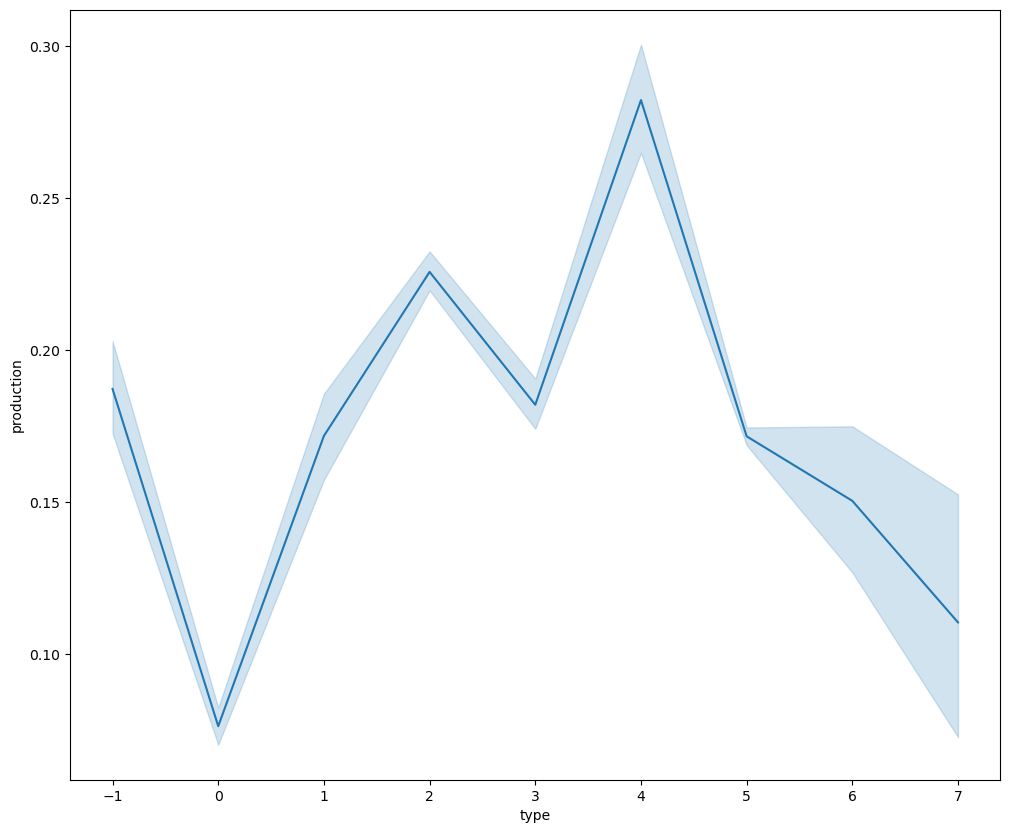

In [599]:
#Gráfico por tipo de árvore
_, eixos = plt.subplots(figsize=(12, 10))
sns.lineplot(x='type', y='production', data=all_data, ax=eixos)
plt.savefig('graph/byType_prod.png')